# Compute correlation function with error bars using log-normal mocks

In [2]:
import time
from tqdm.notebook import tqdm

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
bias = 1.8

#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

## Split density

In [4]:
cellsize = 20
resampler = 'tsc'

catalog_density = split_density(catalog, cellsize, resampler, nsplits=2, save=False, output_dir=output_dir)

edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))
catalog_CCFs = compute_densitySplit_CCF(catalog_density, edges, los='x')

ells = (0, 2)
nells = len(ells)
catalog_split_xiell_gg = [result.get_corr(ells=ells, return_sep=False) for result in catalog_CCFs['gg']]
catalog_split_xiell_dg = [result.get_corr(ells=ells, return_sep=False) for result in catalog_CCFs['dg']]

[000000.19] [0/1] 05-03 10:05  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2934922.
[000000.90] [0/1] 05-03 10:05  CatalogMesh               INFO     Painted 2934922 out of 2934922 objects to mesh.
[000003.18] [0/1] 05-03 10:05  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000003.18] [0/1] 05-03 10:05  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000028.63] [0/1] 05-03 10:05  TwoPointCorrelationFunction INFO     Analytically computing two-point counts R1R2.
[000028.63] [0/1] 05-03 10:05  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000028.63] [0/1] 05-03 10:05  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000063.87] [0/1] 05-03 10:06  TwoPointCorrelationFunction INFO     Analytically computing two-point counts R1R2.
[000063.87] [0/1] 05-03 10:06  TwoPointCorrelationFunction INFO     Us

In [5]:
s = catalog_CCFs['gg'][0].seps[0][:, 0]

## Generate log-normal mocks and compute cross-correlation function on density splits

In [6]:
nmocks = 1000

In [7]:
results_gg = np.load(output_dir+catalog.name+'_1000_mocks_densitySplit_gg_CCF.npy', allow_pickle=True)
results_dg = np.load(output_dir+catalog.name+'_1000_mocks_densitySplit_dg_CCF.npy', allow_pickle=True)

## Compute covariance matrix

In [8]:
def get_poles(results, ells):
    nells = len(ells)
    n = len(results)
    nsplits = len(results[0])
    
    xiell = list()
    cov = list()
    
    for i in range(nsplits):
        results_poles = [np.ravel(res[i].get_corr(ells=ells, return_sep=False)) for res in results]
        poles = np.mean(results_poles, axis=0)
        xiell.append(poles.reshape((nells, len(poles)//nells)))
    
    cov = np.cov([np.ravel([res[i].get_corr(ells=ells, return_sep=False) for i in range(nsplits)]) for res in results], rowvar=False)

    return xiell, cov

In [9]:
ells = [0]
nells = len(ells)

xiell_gg, cov_gg = get_poles(results_gg, ells)
xiell_dg, cov_dg = get_poles(results_dg, ells)

In [11]:
np.save(output_dir+catalog.name+'_1000_mocks_densitySplit_gg_CCF_monopole_cov', (s, xiell_gg, cov_gg))
np.save(output_dir+catalog.name+'_1000_mocks_densitySplit_dg_CCF_monopole_cov', (s, xiell_dg, cov_dg))

In [22]:
nsplits = 2

In [23]:
std_gg = np.array_split(np.array(np.array_split(np.diag(cov_gg)**0.5, nells)), nsplits, axis=1)
std_dg = np.array_split(np.array(np.array_split(np.diag(cov_dg)**0.5, nells)), nsplits, axis=1)

## Covariance matrix

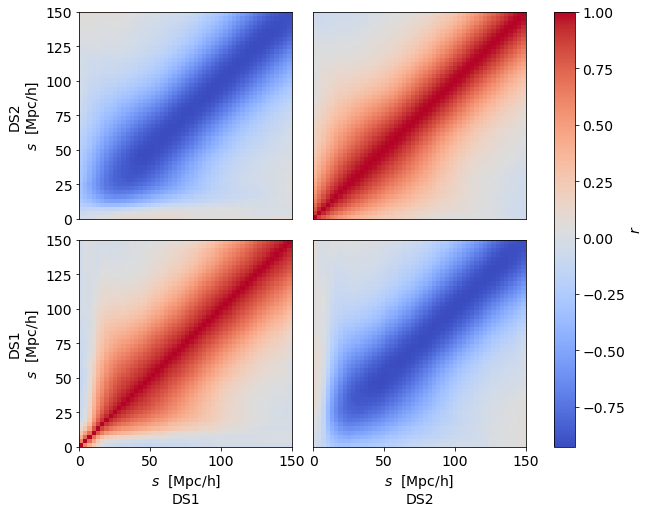

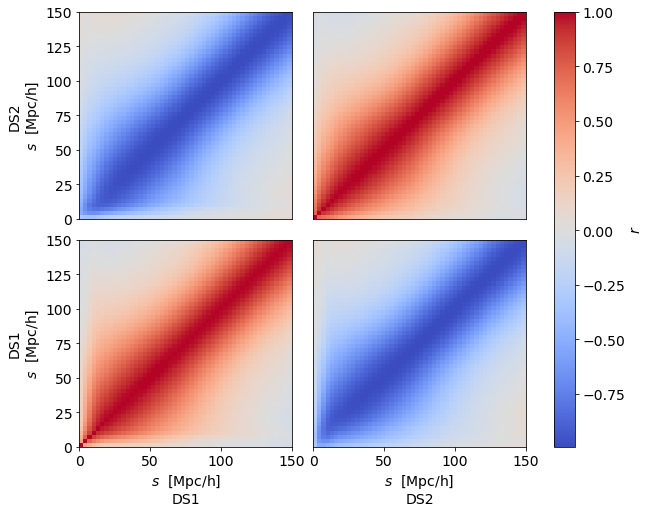

In [28]:
stddev_gg = np.sqrt(np.diag(cov_gg).real)
corrcoef_gg = cov_gg / stddev_gg[:, None] / stddev_gg[None, :]
stddev_dg = np.sqrt(np.diag(cov_dg).real)
corrcoef_dg = cov_dg / stddev_dg[:, None] / stddev_dg[None, :]

from matplotlib.colors import Normalize

def plot_corrcoef(corrcoef, ells, s):
    ns = len(s)
    nells = len(ells)
    
    fig, lax = plt.subplots(nrows=nells*nsplits, ncols=nells*nsplits, sharex=False, sharey=False, figsize=(10, 8), squeeze=False)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    norm = Normalize(vmin=corrcoef.min(), vmax=corrcoef.max())
    for i in range(nells*nsplits):
        for j in range(nells*nsplits):
            ax = lax[nells*nsplits-1-i][j]
            mesh = ax.pcolor(s, s, corrcoef[i*ns:(i+1)*ns,j*ns:(j+1)*ns].T, norm=norm, cmap=plt.get_cmap('coolwarm'))
            if i>0: ax.xaxis.set_visible(False)
            else: ax.set_xlabel(r'$s$  [Mpc/h]'
                                #+'\n'+r'$\ell={}$'.format(ells[j//nsplits])
                                +'\n''DS{}'.format(j//nells +1))
            if j>0: ax.yaxis.set_visible(False)
            else: ax.set_ylabel('DS{}'.format(i//nells +1)
                                #+'\n'+r'$\ell={}$'.format(ells[i//nsplits])
                                +'\n'+r'$s$  [Mpc/h]')
    fig.colorbar(mesh, ax=lax, label=r'$r$')
    plt.show()
    
plot_corrcoef(corrcoef_gg, ells, s)
plot_corrcoef(corrcoef_dg, ells, s)

## Plot correlation function with error bars

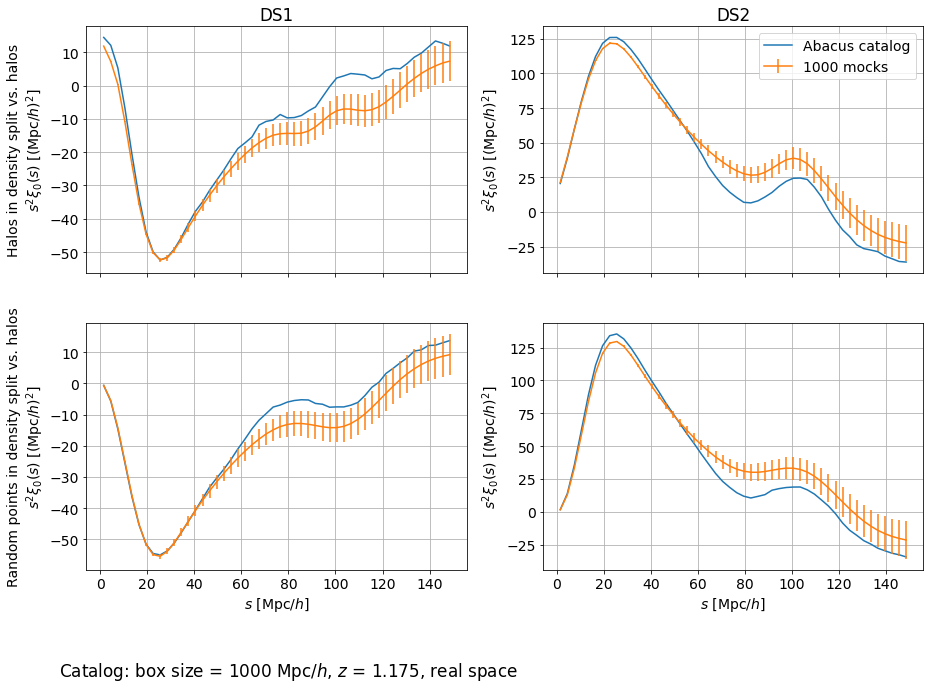

In [14]:
plt.rcParams["figure.figsize"] = (15, 10)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False)

for i in range(catalog_density.nsplits):
    
    axes[0][i].plot(s, s**2 * catalog_split_xiell_gg[i][0], label='Abacus catalog')
    axes[0][i].errorbar(s, s**2 * xiell_gg[i][0], s**2 * std_gg[i][0], fmt='-', label='{} mocks'.format(nmocks))
    axes[0][i].grid(True)

    axes[1][i].plot(s, s**2 * catalog_split_xiell_dg[i][0], label='Abacus catalog')
    axes[1][i].errorbar(s, s**2 * xiell_dg[i][0], s**2 * std_dg[i][0], fmt='-', label='{} mocks'.format(nmocks))
    axes[1][i].grid(True)

    axes[0][i].set_title('DS{}'.format(i+1))    
    axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0][0].set_ylabel('Halos in density split vs. halos' + '\n'
                      + r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0][1].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel('Random points in density split vs. halos' + '\n'
                      + r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][1].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, real space'.format(catalog.boxsize, catalog.redshift),
             ha='left', x=0.1, y=0)

axes[0][1].legend()
plt.show()

## Add 2 Gpc catalog

In [16]:
catalog2 = catalog_data.Data.load(data_dir+'AbacusSummit_2Gpc_z1.175.npy')
catalog2.shift_boxcenter(-catalog2.offset)
catalog2_density = split_density(catalog2, cellsize, resampler, nsplits=2, save=False, output_dir=output_dir)
catalog2_CCFs = compute_densitySplit_CCF(catalog2_density, edges, los='x')
catalog2_split_xiell_gg = [result.get_corr(ells=ells, return_sep=False) for result in catalog2_CCFs['gg']]
catalog2_split_xiell_dg = [result.get_corr(ells=ells, return_sep=False) for result in catalog2_CCFs['dg']]

[000084.15] [0/1] 05-02 17:22  CatalogMesh               INFO     Slab 0 ~ 4194304 / 23463294.
[000085.30] [0/1] 05-02 17:22  CatalogMesh               INFO     Painted 4194304 out of 23463294 objects to mesh.
[000085.30] [0/1] 05-02 17:22  CatalogMesh               INFO     Slab 4194304 ~ 8388608 / 23463294.
[000086.44] [0/1] 05-02 17:22  CatalogMesh               INFO     Painted 8388608 out of 23463294 objects to mesh.
[000086.44] [0/1] 05-02 17:22  CatalogMesh               INFO     Slab 8388608 ~ 12582912 / 23463294.
[000087.58] [0/1] 05-02 17:22  CatalogMesh               INFO     Painted 12582912 out of 23463294 objects to mesh.
[000087.58] [0/1] 05-02 17:22  CatalogMesh               INFO     Slab 12582912 ~ 16777216 / 23463294.
[000088.73] [0/1] 05-02 17:22  CatalogMesh               INFO     Painted 16777216 out of 23463294 objects to mesh.
[000088.73] [0/1] 05-02 17:22  CatalogMesh               INFO     Slab 16777216 ~ 20971520 / 23463294.
[000089.87] [0/1] 05-02 17:22  Cat

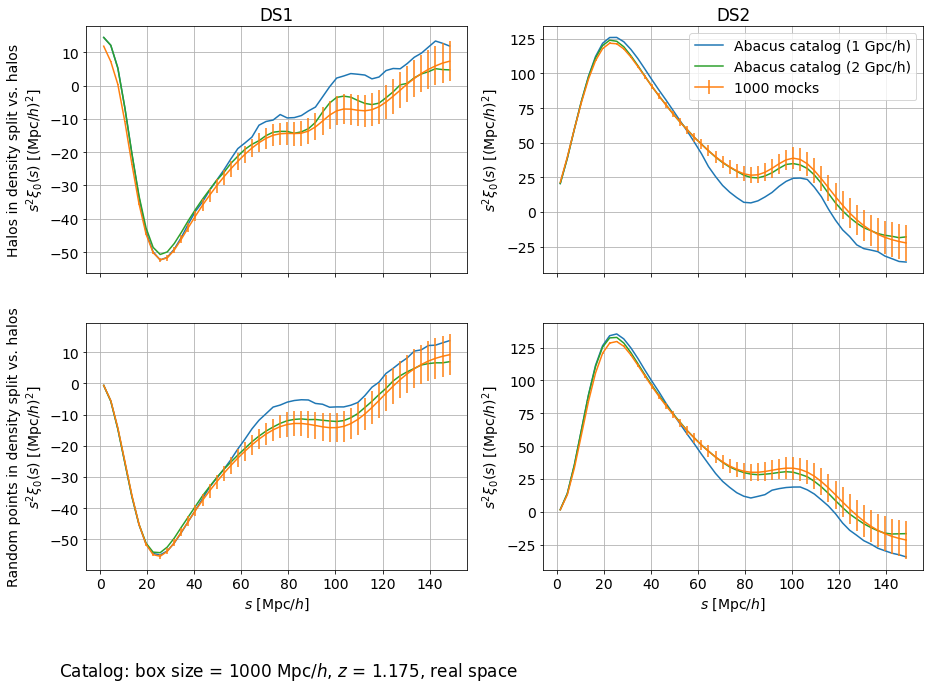

In [19]:
plt.rcParams["figure.figsize"] = (15, 10)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False)

for i in range(catalog_density.nsplits):
    
    axes[0][i].plot(s, s**2 * catalog_split_xiell_gg[i][0], label='Abacus catalog (1 Gpc/h)', color='C0')
    axes[0][i].plot(s, s**2 * catalog2_split_xiell_gg[i][0], label='Abacus catalog (2 Gpc/h)', color='C2')
    axes[0][i].errorbar(s, s**2 * xiell_gg[i][0], s**2 * std_gg[i][0], fmt='-', label='{} mocks'.format(nmocks), color='C1')
    axes[0][i].grid(True)

    axes[1][i].plot(s, s**2 * catalog_split_xiell_dg[i][0], label='Abacus catalog (1 Gpc/h)', color='C0')
    axes[1][i].plot(s, s**2 * catalog2_split_xiell_dg[i][0], label='Abacus catalog (2 Gpc/h)', color='C2')
    axes[1][i].errorbar(s, s**2 * xiell_dg[i][0], s**2 * std_dg[i][0], fmt='-', label='{} mocks'.format(nmocks), color='C1')
    axes[1][i].grid(True)

    axes[0][i].set_title('DS{}'.format(i+1))    
    axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0][0].set_ylabel('Halos in density split vs. halos' + '\n'
                      + r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0][1].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel('Random points in density split vs. halos' + '\n'
                      + r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][1].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, real space'.format(catalog.boxsize, catalog.redshift),
             ha='left', x=0.1, y=0)

axes[0][1].legend()
plt.show()